In [2]:
# Import dependencies needed for the project
import requests
import lxml.html as lh
import pandas as pd
from sqlalchemy import create_engine
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import time
import math

### ETL PROJECT: Trump Tweets vs MEX dB
### Jorge Marquez
### Nestor Matus
### Gonzalo Cienfuegos

### EXTRACT 1) Store Exchange Rate (MXP/USD) CSV into DF
### Source: http://www.banxico.org.mx/tipcamb/tipCamMIAction.do?idioma=sp

In [3]:
# Read csv from given route
e_r_data_df = pd.read_csv("Resources/exchange_rate.csv")

# Show dataframe data
e_r_data_df.head()

,Fecha,Determinación,Publicación DOF,Para solventar obligaciones
0,NaN,NaN,NaN,NaN
1,02/01/2006,10.6253,10.6344,10.7109
2,03/01/2006,10.6455,10.6253,10.6344
3,04/01/2006,10.5815,10.6455,10.6253
4,05/01/2006,10.5907,10.5815,10.6455


### TRANSFORM 1) Reformat date and columns renaming

In [4]:
# Transform date with format Y/M/D to Y-M-D 
e_r_data_df["Fecha"] = pd.to_datetime(e_r_data_df.Fecha)

# Clean column without NA values
e_r_data_df = e_r_data_df.dropna(how="any")

e_r_data_df.dtypes
#depending on Python Version the output for column #4 is different for the next code step

Fecha                           datetime64[ns]
Determinación                           object
Publicación\nDOF                        object
Para solventar\nobligaciones           float64
dtype: object

In [17]:
#Code lines thar run in Python v.3.6.8:
#e_r_data_df = e_r_data_df[["Fecha", "Para solventar\r\nobligaciones"]]
#e_r_data_df = e_r_data_df.rename(columns={'Fecha': 'date', 'Para solventar\r\nobligaciones': 'exchange_rate'})
#Code lines that run in Python v3.7.3
e_r_data_df = e_r_data_df[["Fecha", "Para solventar\nobligaciones"]]
e_r_data_df = e_r_data_df.rename(columns={'Fecha': 'date', 'Para solventar\nobligaciones': 'exchange_rate'})
e_r_data_df = e_r_data_df[["date", "exchange_rate"]]
e_r_data_df.head()

,date,exchange_rate
1,2006-02-01,10.7109
2,2006-03-01,10.6344
3,2006-04-01,10.6253
4,2006-05-01,10.6455
5,2006-06-01,10.5815


## EXTRACT 2) Store Tweets CSV into DF
### Source: http://www.trumptwitterarchive.com/

In [18]:
#read CSV
csv_file = "Resources/trump_vs_mex.csv"

In [19]:
#Create dataframe and display
tweets = pd.read_csv(csv_file, encoding = "ISO-8859-1")
tweets.head()

,source,text,created_at,retweet_count,favorite_count,is_retweet,id_str
0,Twitter for iPhone,RT @VP: Earlier this year President @realDonal...,07/12/2019 22:14,11433.0,0.0,True,1.149800e+18
1,Twitter for iPhone,....companies to come to the USA and to get co...,07/12/2019 12:48,9842.0,49450.0,False,1.149660e+18
2,Twitter for iPhone,.....if Mexico produces (which I think they wi...,07/12/2019 12:48,10001.0,50049.0,False,1.149660e+18
3,Twitter for iPhone,RT @PAChamber: Trade with Canada and Mexico su...,07/12/2019 03:26,4308.0,0.0,True,1.149520e+18
4,Twitter for iPhone,Mexico is doing great at the Border but China ...,07/11/2019 14:04,11612.0,48964.0,False,1.149320e+18


In [20]:
#Clean data
tweets_clean = tweets
tweets_clean["created_at"] = pd.to_datetime(tweets_clean["created_at"])
tweets_clean['Date'], tweets_clean['Time'] = tweets_clean['created_at'].dt.normalize(), tweets_clean['created_at'].dt.time
tweets_clean.set_index('Date').head()

,source,text,created_at,retweet_count,favorite_count,is_retweet,id_str,Time
Date,,,,,,,,
2019-07-12,Twitter for iPhone,RT @VP: Earlier this year President @realDonal...,2019-07-12 22:14:00,11433.0,0.0,True,1.149800e+18,22:14:00
2019-07-12,Twitter for iPhone,....companies to come to the USA and to get co...,2019-07-12 12:48:00,9842.0,49450.0,False,1.149660e+18,12:48:00
2019-07-12,Twitter for iPhone,.....if Mexico produces (which I think they wi...,2019-07-12 12:48:00,10001.0,50049.0,False,1.149660e+18,12:48:00
2019-07-12,Twitter for iPhone,RT @PAChamber: Trade with Canada and Mexico su...,2019-07-12 03:26:00,4308.0,0.0,True,1.149520e+18,03:26:00
2019-07-11,Twitter for iPhone,Mexico is doing great at the Border but China ...,2019-07-11 14:04:00,11612.0,48964.0,False,1.149320e+18,14:04:00


### TRANSFORM 2) Columns rename, merging both DF and slicing ath the same time

In [21]:
#Create new dataframe
new_tweets = tweets_clean[["Date", "id_str", "text","retweet_count"]].set_index('id_str')
#rename columns
new_tweets = new_tweets.rename(columns={"text" :"tweet", 
                           "Date": "date"})
new_tweets.index.names = ['id']
new_tweets = new_tweets.dropna()
#drop retweets
new_tweets =new_tweets[~new_tweets.tweet.str.startswith('RT @')]
#filter by date
#new_tweets.loc['2015-01-01':'2019-08-22']
new_tweets = new_tweets[(new_tweets['date']>dt.date(2015,1,1)) & (new_tweets['date']<dt.date(2019,8,1))]  

C:\Users\Gonzalo\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.
  if sys.path[0] == '':


In [22]:
new_tweets.head()

,date,tweet,retweet_count
id,,,
1.149660e+18,2019-07-12,....companies to come to the USA and to get co...,9842.0
1.149660e+18,2019-07-12,.....if Mexico produces (which I think they wi...,10001.0
1.149320e+18,2019-07-11,Mexico is doing great at the Border but China ...,11612.0
1.146510e+18,2019-07-03,Mexico is doing a far better job than the Demo...,24713.0
1.144370e+18,2019-06-27,Bipartisan Humanitarian Aid Bill for the South...,25170.0


In [23]:
urls_list = ['https://www.gunviolencearchive.org/reports/mass-shooting',
            'https://www.gunviolencearchive.org/reports/mass-shooting?page=1',
            'https://www.gunviolencearchive.org/reports/mass-shooting?page=2',
            'https://www.gunviolencearchive.org/reports/mass-shooting?page=3',
            'https://www.gunviolencearchive.org/reports/mass-shooting?page=4',
            'https://www.gunviolencearchive.org/reports/mass-shooting?page=5',
            'https://www.gunviolencearchive.org/reports/mass-shooting?page=6',
            'https://www.gunviolencearchive.org/reports/mass-shooting?page=7',
            'https://www.gunviolencearchive.org/reports/mass-shooting?page=8',
            'https://www.gunviolencearchive.org/reports/mass-shooting?page=9',
            'https://www.gunviolencearchive.org/reports/mass-shooting?page=10'
             ]
df1 = pd.DataFrame()
for url in urls_list:
    #Create a handle, page, to handle the contents of the website
    page = requests.get(url)
    #Store the contents of the website under doc
    doc = lh.fromstring(page.content)
    #Parse data that are stored between <tr>..</tr> of HTML
    tr_elements = doc.xpath('//tr')

    tr_elements = doc.xpath('//tr')
    #Create empty list
    col=[]
    i=0
    #For each row, store each first element (header) and an empty list
    for t in tr_elements[0]:
        i+=1
        name=t.text_content()
        col.append((name,[]))

    #Since out first row is the header, data is stored on the second row onwards
    for j in range(1,len(tr_elements)):
        #T is our j'th row
        T=tr_elements[j]

        #If row is not of size 7, the //tr data is not from our table 
        if len(T)!=7:
            break

        #i is the index of our column
        i=0

        #Iterate through each element of the row
        for t in T.iterchildren():
            data=t.text_content() 
            #Check if row is empty
            if i>0:
            #Convert any numerical value to integers
                try:
                    data=int(data)
                except:
                    pass
            #Append the data to the empty list of the i'th column
            col[i][1].append(data)
            #Increment i for the next column
            i+=1

    Dict={title:column for (title,column) in col}
    df=pd.DataFrame(Dict)
    df1 = df1.append(df)

In [24]:
df1.head()

,Incident Date,State,City Or County,Address,# Killed,# Injured,Operations
0,"August 23, 2019",Missouri,Saint Louis,918 Union,1,3,View Incident\nView Source\n
1,"August 23, 2019",Texas,Houston,4900 block of Southwind St,3,2,View Incident\nView Source\n
2,"August 22, 2019",South Carolina,Columbia,851 Bush River Rd,2,2,View Incident\nView Source\n
3,"August 22, 2019",California,Los Angeles,300 block of West Fifth St,0,4,View Incident\nView Source\n
4,"August 20, 2019",Georgia,Atlanta,111 James P Brawley Dr SW,0,4,View Incident\nView Source\n


In [25]:
mass_shooting_df = df1[["Incident Date", "# Killed"]]
mass_shooting_df = mass_shooting_df.rename(columns={'Incident Date': 'date',
                                                    '# Killed': 'number_killed'})
mass_shooting_df["date"] = pd.to_datetime(mass_shooting_df.date)
mass_shooting_df = mass_shooting_df.groupby(['date']).sum()
mass_shooting_df = mass_shooting_df.loc[(mass_shooting_df.number_killed > 0)]
mass_shooting_df.reset_index(level=0, inplace=True)
mass_shooting_df.head()

,date,number_killed
0,2019-01-02,1
1,2019-01-03,1
2,2019-01-04,6
3,2019-01-13,1
4,2019-01-15,1


### Union dataframe from Rate Exchange and Trump's Twitter and People Killed

In [26]:
union_df = pd.merge(new_tweets, e_r_data_df, how='inner', on = 'date').set_index(['date'])
union_df = pd.merge(union_df, mass_shooting_df, how='left', on = 'date').set_index(['date'])
union_df.head()

,tweet,retweet_count,exchange_rate,number_killed
date,,,,
2019-07-03,Mexico is doing a far better job than the Demo...,24713.0,19.2597,2.0
2019-06-27,Bipartisan Humanitarian Aid Bill for the South...,25170.0,19.2271,NaN
2019-06-23,I want to give the Democrats every last chance...,24276.0,18.9804,10.0
2019-06-19,Congratulations to President Lopez Obrador  M...,22674.0,19.1924,NaN
2019-06-18,Next week ICE will begin the process of removi...,37105.0,19.1487,1.0


In [27]:
union_df.dtypes

tweet             object
retweet_count    float64
exchange_rate    float64
number_killed    float64
dtype: object

In [28]:
union_df.loc[union_df['number_killed'].notnull()]

,tweet,retweet_count,exchange_rate,number_killed
date,,,,
2019-07-03,Mexico is doing a far better job than the Demo...,24713.0,19.2597,2.0
2019-06-23,I want to give the Democrats every last chance...,24276.0,18.9804,10.0
2019-06-18,Next week ICE will begin the process of removi...,37105.0,19.1487,1.0
2019-06-08,I would like to thank the President of Mexico ...,29037.0,19.3116,5.0
2019-06-08,Everyone very excited about the new deal with ...,20616.0,19.3116,5.0
2019-06-08,MEXICO HAS AGREED TO IMMEDIATELY BEGIN BUYING ...,34068.0,19.3116,5.0
2019-06-08,Mexico will try very hard and if they do that ...,17182.0,19.3116,5.0
2019-06-08,Brandon Judd National Border Patrol Council: ...,16512.0,19.3116,5.0
2019-06-08,While the reviews and reporting on our Border ...,15815.0,19.3116,5.0


### LOAD: Create database connection and load information into dB

In [29]:
connection_string = "postgres:postgres@localhost:5432/trump_vs_mex_db"
engine = create_engine(f'postgresql://{connection_string}')

In [30]:
# Confirm tables
engine.table_names()

['trump_twitter']

### Load DataFrames into database

In [31]:
union_df.to_sql(name='trump_twitter', con=engine, if_exists='append', index = True)

In [32]:
#Create arrays
t = union_df.index
data1 = union_df['retweet_count']/1000
data2 = union_df['exchange_rate']

C:\Users\Gonzalo\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


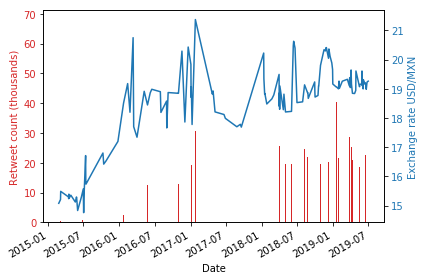

In [33]:
#plot

fig, ax1 = plt.subplots()
color = 'tab:red'
fig.autofmt_xdate()
#xfmt = mdates.DateFormatter('%d-%m-%y')


ax1.set_xlabel('Date')
ax1.set_ylabel('Retweet count (thousands)', color=color)
ax1.bar(t, data1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Exchange rate USD/MXN', color=color)  # we already handled the x-label with ax1
ax2.plot(t, data2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout() # otherwise the right y-label is slightly clipped
plt.savefig("..\\ETL_Project\\plot.png")
plt.show()

In [34]:
#Correlation
union_df['retweet_count'].corr(union_df['exchange_rate'])

0.6449590687780054

In [35]:
union_df['retweet_count'].corr(union_df['number_killed'])

-0.07133777237347126

In [ ]:
# THE END